# Exercise 2: Evaluating a decision tree

This notebook uses the packages and versions described in [requirements.txt](https://github.com/jpivarski/scipy2022-loopy/blob/main/requirements.txt).

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.tree
import matplotlib
import matplotlib.pyplot as plt

Array-oriented programming is usually concerned with number-crunching, such as simulations or data analysis. Usually not data structures. However, graphs and trees can be expressed in terms of arrays.

In this exercise, we'll take a decision tree built by Scikit-Learn and traverse it in an array-oriented way. It may seem that this isn't a good problem for array-oriented programming because it has to "iterate until converged" (walk down the tree until you reach a leaf node), but other advantages outweigh it.

## Making a decision tree

To begin, let's give Scikit-Learn's decision tree package a classification problem and solve it.

In [2]:
X1, y1 = sklearn.datasets.make_gaussian_quantiles(
    cov=2.0, n_samples=500, n_features=2, n_classes=2, random_state=1
)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=1000, n_features=2, n_classes=2, random_state=1
)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

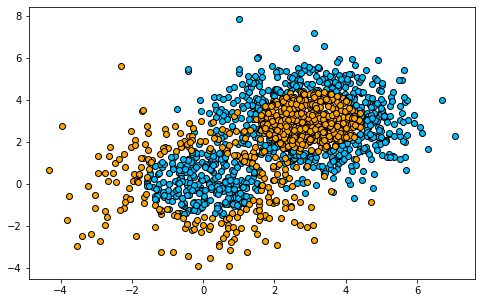

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black");
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black");

The objective is to find a function of _x_ and _y_ that predicts whether a dot will be orange or blue.

There are a lot of machine learning algorithms that do this, but we'll use an old standard: a decision tree.

In [4]:
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=10)

The function of _x_ and _y_ colors the plane below. The original points are overlaid with transparency.

(Standard) decision trees are restricted to horizontal and vertical cuts. This one is overfitted, as the region between the two blobs is finely divided into horizontal and vertical bands meant to catch a few of the overlapping points.

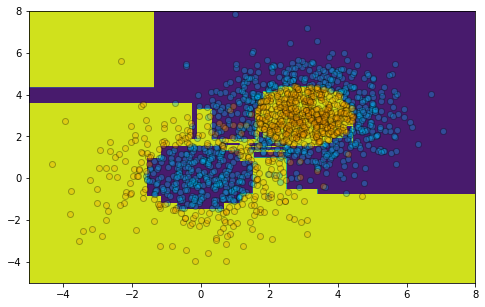

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

It's not important whether this is a good fit; what's important is that we now have a tree to play with.

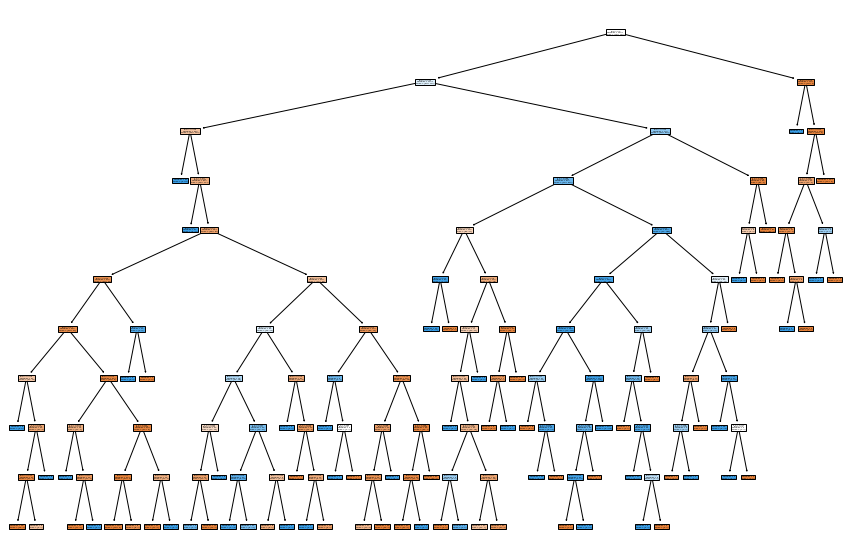

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sklearn.tree.plot_tree(decision_tree, feature_names=["x", "y"], filled=True, ax=ax);

<br><br><br><br><br>

In introductory computer science classes, trees are often introduced as data structures like this:

In [7]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class Node:
    feature: str
    threshold: float
    left: Optional["Node"]
    right: Optional["Node"]
    winner: str

    def predict(self, x: float, y: float) -> str:
        if self.left is None and self.right is None:
            return self.winner
        
        elif self.left is None:
            return self.right.predict(x, y)
        
        elif self.right is None:
            return self.left.predict(x, y)
        
        else:
            if self.feature == "x":
                value = x
            else:
                value = y

            if value <= self.threshold:
                return self.left.predict(x, y)
            else:
                return self.right.predict(x, y)

In [8]:
tree = Node(
    "x",
    3.14,
    Node(
        "y",
        2.71,
        None,
        None,
        "orange",
    ),
    Node(
        "x",
        1.62,
        None,
        None,
        "blue",
    ),
    "neither",
)

That is, a node object contains or points to other node objects until reaching the leaves, which do not contain more objects.

This particular tree is a decision tree. It evaluates _x_, _y_ points by holding features ("which component to compare?") and thresholds with which to compare the points and decide to descend to the left or right child.

In [9]:
tree.predict(1, 2)

'orange'

In [10]:
tree.predict(4, 1)

'blue'

<br><br><br><br><br>

It is a flow chart.

<img src="../img/flowchart.png" width="500">

<br><br><br><br><br>

However, it may be surprising to learn that the tree is stored in arrays.

In [11]:
decision_tree.tree_.feature

array([ 1,  1,  1, -2,  0, -2,  0,  1,  0,  1, -2,  1,  1, -2, -2, -2,  1,
        0, -2,  0, -2, -2,  1,  0, -2, -2,  0, -2, -2,  0, -2, -2,  0,  1,
        0,  1,  1, -2, -2, -2,  1,  0, -2, -2,  1, -2, -2,  0, -2,  1, -2,
        1, -2, -2,  1,  1, -2,  0, -2, -2,  0,  1,  1, -2, -2, -2,  1,  1,
       -2, -2, -2,  0,  0,  0,  1, -2, -2,  1,  0,  1, -2,  0,  0, -2, -2,
        0, -2, -2, -2,  1,  1, -2, -2, -2,  0,  1,  1,  0, -2,  0, -2, -2,
        0,  1,  1, -2, -2, -2, -2,  0,  0, -2,  0, -2,  1, -2, -2, -2,  1,
        1,  0,  1, -2, -2, -2,  1, -2,  0, -2, -2, -2,  0,  1, -2, -2, -2,
        0, -2,  1,  1,  1, -2,  1, -2, -2,  0, -2, -2, -2], dtype=int64)

In [12]:
decision_tree.tree_.threshold

array([ 4.36631989,  1.71515965, -1.4836058 , -2.        , -1.57952124,
       -2.        ,  1.14043081,  1.57191008, -1.16847849, -0.87495318,
       -2.        ,  0.99008071,  0.6111871 , -2.        , -2.        ,
       -2.        , -1.21125579, -0.6881648 , -2.        ,  0.6916993 ,
       -2.        , -2.        ,  1.3412472 ,  1.07069945, -2.        ,
       -2.        ,  0.62893662, -2.        , -2.        ,  0.65427282,
       -2.        , -2.        ,  2.49822414,  1.35090911,  1.53299499,
        0.85208771, -0.755288  , -2.        , -2.        , -2.        ,
        0.96735635,  1.96666145, -2.        , -2.        ,  1.27757668,
       -2.        , -2.        ,  1.41298074, -2.        ,  1.51176906,
       -2.        ,  1.52996832, -2.        , -2.        , -0.52911276,
       -0.77135825, -2.        ,  3.39272106, -2.        , -2.        ,
        3.58306742,  1.56804949,  0.83365068, -2.        , -2.        ,
       -2.        ,  1.16806632,  1.16440243, -2.        , -2.  

In [13]:
decision_tree.tree_.children_left

array([  1,   2,   3,  -1,   5,  -1,   7,   8,   9,  10,  -1,  12,  13,
        -1,  -1,  -1,  17,  18,  -1,  20,  -1,  -1,  23,  24,  -1,  -1,
        27,  -1,  -1,  30,  -1,  -1,  33,  34,  35,  36,  37,  -1,  -1,
        -1,  41,  42,  -1,  -1,  45,  -1,  -1,  48,  -1,  50,  -1,  52,
        -1,  -1,  55,  56,  -1,  58,  -1,  -1,  61,  62,  63,  -1,  -1,
        -1,  67,  68,  -1,  -1,  -1,  72,  73,  74,  75,  -1,  -1,  78,
        79,  80,  -1,  82,  83,  -1,  -1,  86,  -1,  -1,  -1,  90,  91,
        -1,  -1,  -1,  95,  96,  97,  98,  -1, 100,  -1,  -1, 103, 104,
       105,  -1,  -1,  -1,  -1, 110, 111,  -1, 113,  -1, 115,  -1,  -1,
        -1, 119, 120, 121, 122,  -1,  -1,  -1, 126,  -1, 128,  -1,  -1,
        -1, 132, 133,  -1,  -1,  -1, 137,  -1, 139, 140, 141,  -1, 143,
        -1,  -1, 146,  -1,  -1,  -1], dtype=int64)

In [14]:
decision_tree.tree_.children_right

array([136,  71,   4,  -1,   6,  -1,  32,  29,  16,  11,  -1,  15,  14,
        -1,  -1,  -1,  22,  19,  -1,  21,  -1,  -1,  26,  25,  -1,  -1,
        28,  -1,  -1,  31,  -1,  -1,  54,  47,  40,  39,  38,  -1,  -1,
        -1,  44,  43,  -1,  -1,  46,  -1,  -1,  49,  -1,  51,  -1,  53,
        -1,  -1,  60,  57,  -1,  59,  -1,  -1,  66,  65,  64,  -1,  -1,
        -1,  70,  69,  -1,  -1,  -1, 131,  94,  77,  76,  -1,  -1,  89,
        88,  81,  -1,  85,  84,  -1,  -1,  87,  -1,  -1,  -1,  93,  92,
        -1,  -1,  -1, 118, 109, 102,  99,  -1, 101,  -1,  -1, 108, 107,
       106,  -1,  -1,  -1,  -1, 117, 112,  -1, 114,  -1, 116,  -1,  -1,
        -1, 130, 125, 124, 123,  -1,  -1,  -1, 127,  -1, 129,  -1,  -1,
        -1, 135, 134,  -1,  -1,  -1, 138,  -1, 148, 145, 142,  -1, 144,
        -1,  -1, 147,  -1,  -1,  -1], dtype=int64)

<br><br><br><br><br>

Although it may not be clear how `decision_tree.tree_.feature` and `decision_tree.tree_.threshold` are arranged into a tree, their values should be recognizable as the `Node.feature` and `Node.threshold` values in our simple tree.

The key to the structure is `decision_tree.tree_.children_left` and `decision_tree.tree_.children_right`. Many of these values are `-1`, which I'll tell you represent terminal nodes (i.e. leaves). What are the other values?

<br><br><br><br><br><br><br><br><br><br>

They're "pointers" to child nodes as array indexes!

Suppose we start at `0`, the root of the tree, and always traverse to the right.

In [15]:
index = 0

while index >= 0:
    print(index)
    index = decision_tree.tree_.children_right[index]

0
136
138
148


Or zig-zag the left, then right, then left, then right.

In [16]:
index = 0
which_way = "left "

while index >= 0:
    print(which_way, index)

    if which_way == "left ":
        index = decision_tree.tree_.children_left[index]
        which_way = "right"
    else:
        index = decision_tree.tree_.children_right[index]
        which_way = "left "

left  0
right 1
left  71
right 72
left  94
right 95
left  109
right 110
left  112
right 113


So in this case, "array application" means "tree traversal."

<br><br><br><br><br>

To check this interpretation, let's write a recursive tree-walking function and compare it to Scikit-Learn's tree output.

In [17]:
def print_tree(tree, array_index=0, indent="", feature_names=["x", "y"]):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        yield f"{indent}{feature_names[feature]} <= {threshold:.2f}"
        yield from print_tree(tree, left_index, indent + "    ", feature_names)

        yield f"{indent}{feature_names[feature]} > {threshold:.2f}"
        yield from print_tree(tree, right_index, indent + "    ", feature_names)

    else:
        # tree.value is a count of the number of training data of each class that would reach this node
        # the largest number is what this tree predicts
        winner = np.argmax(tree.value[array_index])

        yield f"{indent}class: {winner}"

In [18]:
for mine, theirs in zip(
    print_tree(decision_tree.tree_),
    sklearn.tree.export_text(decision_tree, feature_names=["x", "y"]).split("\n"),
):
    print(f"{mine:60s} {theirs:60s}")

y <= 4.37                                                    |--- y <= 4.37                                              
    y <= 1.72                                                |   |--- y <= 1.72                                          
        y <= -1.48                                           |   |   |--- y <= -1.48                                     
            class: 1                                         |   |   |   |--- class: 1                                   
        y > -1.48                                            |   |   |--- y >  -1.48                                     
            x <= -1.58                                       |   |   |   |--- x <= -1.58                                 
                class: 1                                     |   |   |   |   |--- class: 1                               
            x > -1.58                                        |   |   |   |--- x >  -1.58                                 
                x <= 1.1

This is the correct interpretation!

<br><br><br><br><br>

## Single tree traversal

Scikit-Learn's `decision_tree.predict` function could be implemented for a single _x_, _y_ position by modifying the above function, to walk the tree and report the final leaf node's class.

In [19]:
def predict_single(position, tree, array_index=0):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        if position[feature] <= threshold:
            return predict_single(position, tree, left_index)
        else:
            return predict_single(position, tree, right_index)

    else:
        return np.argmax(tree.value[array_index], axis=1)

To see that this function works, we can make the prediction/training data overlay as above, but evaluating this function instead of Scikit-Learn's.

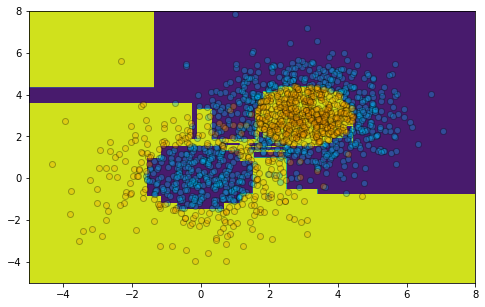

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    [predict_single(position, decision_tree.tree_) for position in np.c_[xx.ravel(), yy.ravel()]]
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

<br><br><br><br><br>

Did you notice the lag? Partly, that's because this function is implemented in pure Python, but also, it's because each walk down the tree is an independent traversal.

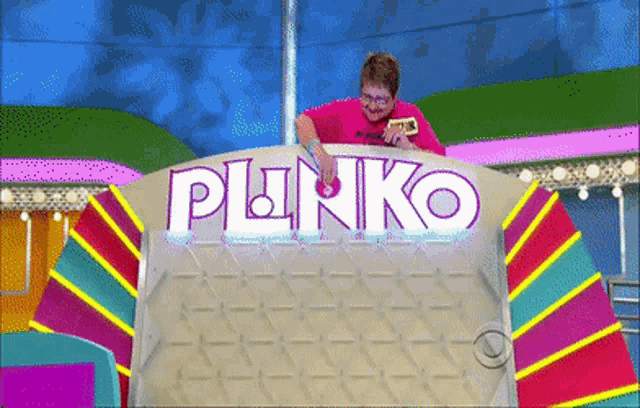

In [21]:
import IPython.display

IPython.display.Image(filename="../img/plinko-price-is-right.gif") 

<br><br><br><br><br>

## THE EXERCISE

The goal of this exercise is to implement tree-traversal for a large set of positions _x_ and _y_.

In [22]:
prepared_data = np.c_[xx.ravel(), yy.ravel()]
prepared_data

array([[-5.  , -5.  ],
       [-4.98, -5.  ],
       [-4.96, -5.  ],
       ...,
       [ 7.94,  7.98],
       [ 7.96,  7.98],
       [ 7.98,  7.98]])

In [23]:
prepared_data.shape

(422500, 2)

There's only one decision tree, but we want all of these input data to walk the tree at the same time.

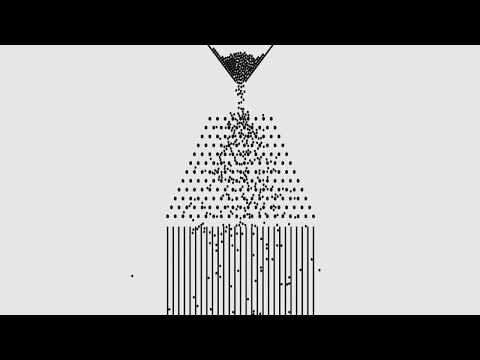

In [24]:
from IPython.display import YouTubeVideo

YouTubeVideo('AuEUAXlbE94', width=600, height=450)

<br><br><br><br><br>

Remember that slicing an array with an array of indexes returns an array of selected items:

In [25]:
array = np.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [26]:
indexes = np.array([4, 3, 3, 1, 6, 7, 8])

In [27]:
array[indexes]

array([4.4, 3.3, 3.3, 1.1, 6.6, 7.7, 8.8])

In [28]:
indexes = np.array([0, 1, 2, 4, 6, 7, 8, 10])

decision_tree.tree_.threshold[indexes]

array([ 4.36631989,  1.71515965, -1.4836058 , -1.57952124,  1.14043081,
        1.57191008, -1.16847849, -2.        ])

<br><br><br><br><br>

There are ways to do this that keep all arrays immutable ("construct and read from arrays, but don't write to them after construction").

There are ways to do this that change arrays after they've been made.

Any of these is acceptable: just produce the same output as running `predict_single` on every item of `prepared_data`.

<br><br><br><br><br>

The interface is

```python
predict_many(positions, tree)
```

where `positions` is the `prepared_data` and `tree` is the `decision_tree.tree_`.

<br><br><br><br><br>

Note that this tree has a maximum depth.

In [29]:
decision_tree.tree_.max_depth

10

<br><br><br><br><br>

**Suggestion:** implement

```python
predict_many_step(positions, tree, array_indexes)
```

to see what one step of descending the tree does to an array of `array_indexes`. As with the Game of Life, you can repeatedly evaluate the cell to animate it.

<br><br><br><br><br>

**Question:** what do you do when some indexes reach leaf nodes and others don't?

<br><br><br><br><br>

<details>
    <summary><b>Hint!</b></summary>

Given an array of `positions` and `features = tree.feature[array_indexes]`, you can identify which ones will be taking the left child by

```python
choosing_left = positions[np.arange(len(positions)), features] <= thresholds
```

<br>

This is a 2-dimensional slice: along the first dimension of `positions` (the 422500 positions), we want every one, so we give it an array of indexes that are `[0, 1, 2, 2, ...]`. Along the second dimension, we pick `0` (_x_) or `1` (_y_), according to the values in the `features` array.

</details>

<br><br><br><br><br>

<details>
    <summary><b>Second hint!</b></summary>

The [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) function acts as an array-oriented if-then-else:

```python
np.where(choosing_left, left_indexes, right_indexes)
```

</details>

<br><br><br><br><br>

<details>
    <summary><b>Third hint!</b></summary>

A reasonable way to make indexes that have already reached leaf node $X$ stop iterating is to define their transition as $X \to X$. They're still "updated," but they're updated to the value they already have. Implementing this uses tools already described in the other hints (i.e. more of the same).

</details>